# ResNet 구현


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
np.random.seed(7777)
tf.random.set_seed(7777)

### ResNet

![](../../statics/imgs/resnet.png)

### ResNet의 핵심은 Skip Connection

![](../../statics/imgs/skipconnection.png)

### 2. Functional API 

`tf.keras.Sequential` 보다 더 유연하게 모델을 정의할 수 있는 방법

In [1]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add

In [4]:
## Functional API 를 이용해 ResNet 구현
def build_resnet(input_shape):
    inputs = Input(input_shape) # 입력 데이터를 받는 첫 번째 레이어 # (28, 28)

    net = Conv2D(32, kernel_size=3, strides=2,
                 padding='same', activation='relu')(inputs) # (14, 14)
    net = MaxPool2D()(net) # (7, 7)
    
    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)
    
    # net과 net3을 더해주어야하는데 filter 개수가 32와 64로 맞지 않는다
    # 이를 맞춰주기 위해 net1_1 생성
    net1_1 = Conv2D(64, kernel_size=1, padding='same')(net)
    net = Add()([net1_1, net3]) # input과 output을 더해준 것
    
    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)
    
    net = Add()([net, net3]) # input과 output을 더해준 것
    
    net = MaxPool2D()(net)
    
    net = Flatten()(net)
    net = Dense(10, activation="softmax")(net)

    model = tf.keras.Model(inputs=inputs, outputs=net, name='resnet')
    
    return model

In [5]:
model = build_resnet((32, 32, 3))
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 8, 8, 32)             0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             2112      ['max_pooling2d[0][0]']  

## CIfar10 dataset을 이용해 학습을 해본다

In [6]:
class Cifar10DataLoader():
    def __init__(self):
        # data load
        (self.train_x, self.train_y), \
            (self.test_x, self.test_y) = tf.keras.datasets.cifar10.load_data()
        self.input_shape = self.train_x.shape[1:]

    def scale(self, x):

        return (x / 255.0).astype(np.float32)

    def preprocess_dataset(self, dataset):

        (feature, target) = dataset

        # scaling #
        scaled_x = np.array([self.scale(x) for x in feature])

        # label encoding #
        ohe_y = np.array([tf.keras.utils.to_categorical(
            y, num_classes=10) for y in target])
        
        return scaled_x, ohe_y.squeeze(1)

    def get_train_dataset(self):
        return self.preprocess_dataset((self.train_x, self.train_y))

    def get_test_dataset(self):
        return self.preprocess_dataset((self.test_x, self.test_y))

In [7]:
cifar10_loader = Cifar10DataLoader()

train_x, train_y = cifar10_loader.get_train_dataset()

print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)

test_x, test_y = cifar10_loader.get_test_dataset()

print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

170498071/170498071 [==============================] - 81s 0us/step
(50000, 32, 32, 3) float32
(50000, 10) float32
(10000, 32, 32, 3) float32
(10000, 10) float32


input shape에 맞게 model 선언

In [8]:
model = build_resnet((32, 32, 3))
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 16, 16, 32)           896       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)             0         ['conv2d_8[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 8, 8, 64)             2112      ['max_pooling2d_2[0][0]']

In [9]:
lr = 0.03
opt = tf.keras.optimizers.Adam(lr)
loss = tf.keras.losses.categorical_crossentropy

model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [10]:
hist = model.fit(train_x, train_y,
                 epochs=10, batch_size=128,
                 validation_data=(test_x, test_y))

Epoch 1/10
391/391 [==============================] - 22s 52ms/step - loss: 2.3711 - accuracy: 0.0977 - val_loss: 2.3066 - val_accuracy: 0.1000
Epoch 2/10
391/391 [==============================] - 21s 55ms/step - loss: 2.3101 - accuracy: 0.1018 - val_loss: 2.3178 - val_accuracy: 0.1000
Epoch 3/10
391/391 [==============================] - 21s 54ms/step - loss: 2.3089 - accuracy: 0.0985 - val_loss: 2.3093 - val_accuracy: 0.1000
Epoch 4/10
391/391 [==============================] - 25s 65ms/step - loss: 2.3088 - accuracy: 0.1001 - val_loss: 2.3073 - val_accuracy: 0.1000
Epoch 5/10
391/391 [==============================] - 31s 80ms/step - loss: 2.3122 - accuracy: 0.1007 - val_loss: 2.3081 - val_accuracy: 0.1000
Epoch 6/10
391/391 [==============================] - 40s 102ms/step - loss: 2.3185 - accuracy: 0.0999 - val_loss: 2.3618 - val_accuracy: 0.1000
Epoch 7/10
391/391 [==============================] - 37s 94ms/step - loss: 2.3236 - accuracy: 0.1010 - val_loss: 2.3168 - val_accuracy

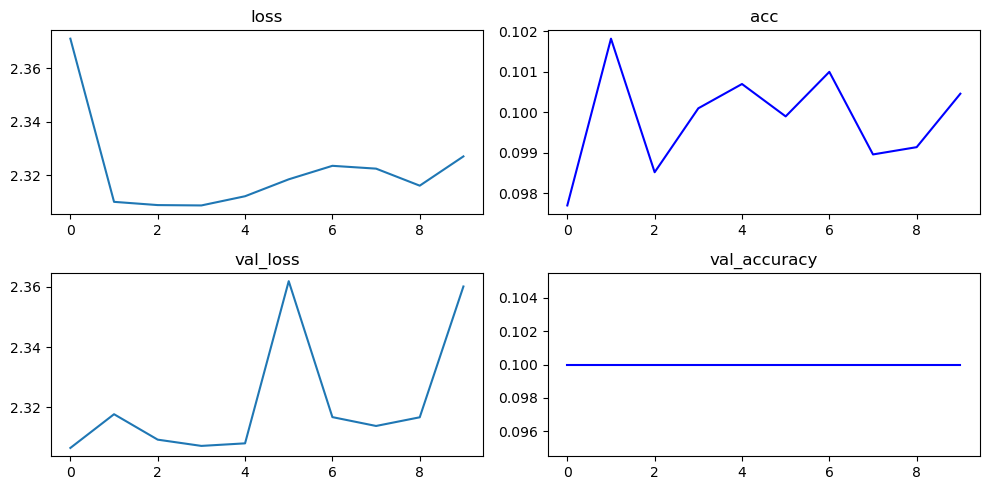

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(221)
plt.plot(hist.history['loss'])
plt.title("loss")
plt.subplot(222)
plt.plot(hist.history['accuracy'], 'b-')
plt.title("acc")
plt.subplot(223)
plt.plot(hist.history['val_loss'])
plt.title("val_loss")
plt.subplot(224)
plt.plot(hist.history['val_accuracy'], 'b-')
plt.title("val_accuracy")

plt.tight_layout()
plt.show()

sequential 보다는 훨씬 모델의 중간의 값을 활용하기도 편하다! 